Author: Pascal, pascal@bayesimpact.org

Date: 2020-06-24

# ROME update from v342 to v343

In March 2020 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v343. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '342'
NEW_VERSION = '343'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


Cool, no new nor deleted files.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
def read_csv(filename):
    try:
        return pd.read_csv(filename)
    except pd.errors.ParserError:
        display(f'While parsing: {filename}')
        raise

rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

OK, let's check what's new in there:

In [5]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')
print(f'New columns: {set(jobs.old.columns) - set(jobs.new.columns)}')
print(f'Old columns: {set(jobs.new.columns) - set(jobs.old.columns)}')

New columns: set()
Old columns: set()


Ouch, it seems they have decided to rename one column, however the opposite change was done when going to v341, so they're just reverting back. Lucky us we never used it.

Now let's see for each file if there are more or less rows.

In [6]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

66/32245 values added in unix_coherence_item_v343_utf8.csv
10/11737 values added in unix_cr_gd_dp_appellations_v343_utf8.csv
14/13645 values added in unix_item_v343_utf8.csv
76/43858 values added in unix_liens_rome_referentiels_v343_utf8.csv
2/8977 values added in unix_referentiel_activite_riasec_v343_utf8.csv
2/8977 values added in unix_referentiel_activite_v343_utf8.csv
10/11081 values added in unix_referentiel_appellation_v343_utf8.csv
6/4929 values added in unix_referentiel_competence_v343_utf8.csv
3/5048 values added in unix_texte_v343_utf8.csv
11/20 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in referentiel_appellation, item, and liens_rome_referentiels, so let's see more precisely.

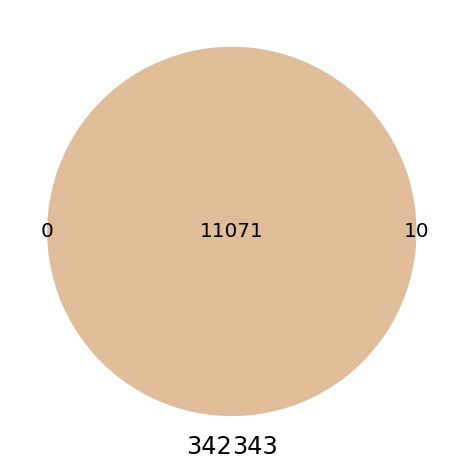

In [7]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 10 new jobs added. Let's take a look (only showing interesting fields):

In [8]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
11071,200080,Ouvrier / Ouvrière de génie écologique,A1202
11072,200081,Ingénieur / Ingénieure écologue,A1303
11073,200082,Ingénieur / Ingénieure méthanisation,A1303
11074,200083,Technicien / Technicienne de génie écologique,A1301
11075,200084,Sertisseur / Sertisseuse en industrie alimentaire,H3301
11076,200085,Responsable de site méthanisation,K2306
11077,200086,Technicien / Technicienne d'exploitation méthanisation,K2306
11078,200087,Télépilote de drone professionnel,N2204
11079,200088,Instructeur / Instructrice télépilote de drone professionnel,N2204
11080,200089,Agent / Agente AFIS - Aerodrone Flight Information Service,N2204


Those are indeed new jobs. Some are related to ecology sneaking in.

OK, let's check at the changes in items:

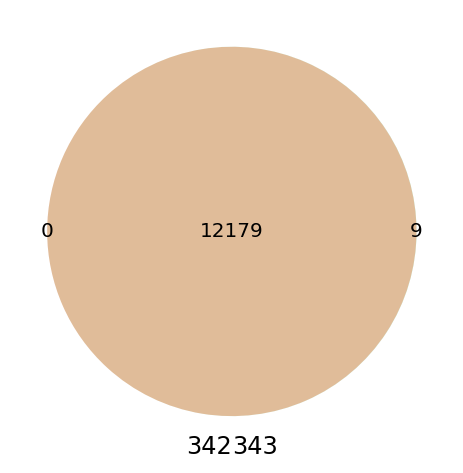

In [9]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): 9 new ones have been created. Let's have a look at them.

In [10]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
12873,200090,"Piloter un drone dans le cadre de captation de données, transport de charges, ...",2,9,NaN,NaN,NaN
12874,200091,Former au pilotage d'un drone,2,9,NaN,NaN,NaN
12875,200092,"Assurer le suivi des intrants (déchets organiques) et des sortants (biogaz, digestats)",2,9,NaN,NaN,NaN
12876,200093,Habilitation au pilotage de drone professionnel,1,10,NaN,NaN,NaN
12877,200094,Scénario de vol S1,1,10,NaN,NaN,NaN


The new ones seem legit to me and related to the new jobs.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [11]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added    43
Name: _diff, dtype: int64

So in addition to the added items, there are few fixes. Let's have a look at them:

In [12]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(5)


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
32179,A1301,122168,right_only,added,Conseil et assistance technique en agriculture et environnement naturel,Coordonner les opérations de réaménagement et de réhabilitation d'un site
32180,A1303,101425,right_only,added,Ingénierie en agriculture et environnement naturel,Réglementation des Installations Classées pour la Protection de l'Environnement - ICPE
32181,A1303,104585,right_only,added,Ingénierie en agriculture et environnement naturel,Biologie
32182,A1303,119432,right_only,added,Ingénierie en agriculture et environnement naturel,Système d'Information Géographique (SIG)
32183,E1106,102644,right_only,added,Journalisme et information média,Caractéristiques des matériels de prise de vues


The added items are OK.

That's all the changes we wanted to check (no change in `referentiel_code_rome`).

# Conclusion

The new version of ROME, v343, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf).

The transition should be transparent with a very small advantage over the old version.